In [74]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
from pandas_profiling import ProfileReport
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
RANDOM_SEED = 42

In [76]:
def na_info(ds: pd.DataFrame) -> pd.DataFrame:
    arr = []
    nans_cnt = ds.isna().sum()
    for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
        name = ind
        if ind.startswith('ind_'):
            name = buh_codes_dict[ind[4:8]]
        arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
    return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


# Корреляция между числовыми признаками набора данных
def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    print('Название:', s.name)
    print('Тип данных:', s.dtype.type)
    print('Количество значений:', len(s))
    print('Количество уникальных значений:', s.nunique())
    print('Количество пропусков:', s.isna().sum())
    print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
    print('Общие статистики:')
    print(s.describe())
    print('Топ 10 уникальных значений:')
    print(s.value_counts()[:10])
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_imortances(fi, columns, num=20):
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model, features, n=20):
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred, y_true):
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=[1, 0])
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred, y_true):
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))



In [77]:
data = pd.read_csv('data/finadvisor/data-2018.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85399 entries, 0 to 85398
Columns: 267 entries, name to subject_rf
dtypes: float64(1), int64(264), object(2)
memory usage: 174.0+ MB


In [78]:
data.head()

,name,okpo,okopf,okfs,okved,org_inn,measure,type,ind_11103,ind_11104,...,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003,extra_field,subject_rf
0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ТЕХИ...",25053919,12300,16,71.11,6671449740,384,2,0,0,...,0,0,0,0,0,0,0,0,20190322,66.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ДОМ ...",26748262,12300,16,60.10,6025050565,384,1,0,0,...,0,0,0,0,0,0,0,0,20190408,60.0
2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МЕДИ...",27234766,12300,16,73.11,6141049497,384,1,0,0,...,0,0,0,0,0,0,0,0,20190314,61.0
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СЕРВ...",27676553,65,16,31.02,6670465179,383,2,0,0,...,0,0,0,0,0,0,0,0,20190429,66.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАНЦ...",34464024,12300,16,47.62.2,6234143407,384,2,874,0,...,0,0,0,0,0,0,0,0,20190328,62.0


In [79]:
# Двухфакторная модель Альтмана
# x1 = Коэффициент текущей ликвидности = Оборотные активы / Краткосрочные обязательства = стр.1200/ (стр.1510+стр.1520);
# x2 = Коэффициент капитализации =(Долгосрочные обязательства + Краткосрочные обязательства) / Собственный капитал = (стр.1400+стр.1500)/ стр.1300.
# Z = -0.3877 - 1.0736 * X1 + 0.0579 * X2
altman1 = ['1200', '1510', '1520', '1400', '1500', '1300']
altman1_columns = []
for ind in altman1:
    altman1_columns += [c for c in data.columns if c.startswith('ind_' + ind) and c.endswith('4')]
altman1_columns

['ind_12004', 'ind_15104', 'ind_15204', 'ind_14004', 'ind_15004', 'ind_13004']

### Предварительная обработка набора

In [80]:
# Заменим 0 на NaN так удобнее работать
for column in tqdm(data.columns, total=len(data.columns)):
    if column.startswith('ind_'):
        data[column] = data[column].apply(lambda x: np.NaN if x == 0 else x)
data.info(max_cols=300)

  0%|          | 0/267 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85399 entries, 0 to 85398
Data columns (total 267 columns):
 #    Column       Non-Null Count  Dtype  
---   ------       --------------  -----  
 0    name         85399 non-null  object 
 1    okpo         85399 non-null  int64  
 2    okopf        85399 non-null  int64  
 3    okfs         85399 non-null  int64  
 4    okved        85399 non-null  object 
 5    org_inn      85399 non-null  int64  
 6    measure      85399 non-null  int64  
 7    type         85399 non-null  int64  
 8    ind_11103    2623 non-null   float64
 9    ind_11104    2512 non-null   float64
 10   ind_11203    63 non-null     float64
 11   ind_11204    57 non-null     float64
 12   ind_11303    24 non-null     float64
 13   ind_11304    20 non-null     float64
 14   ind_11403    24 non-null     float64
 15   ind_11404    21 non-null     float64
 16   ind_11503    23796 non-null  float64
 17   ind_11504    22755 non-null  float64
 18   ind_11603    192 non-nul

In [81]:
# Отделим колонки за последний и предыдущий года
target_columns = []
feature_columns = []
for column in data.columns:
    if column.startswith('ind_'):
        if column.endswith('3'):
            target_columns.append(column)
        else:
            feature_columns.append(column)
    else:
        feature_columns.append(column)
print(f'Current year columns length {len(target_columns)} other columns length {len(feature_columns)}')

Current year columns length 131 other columns length 136


In [82]:
# Расшифровка бухгалтерских кодов
buh_codes = pd.read_csv('data/finadvisor/buh_codes.csv', dtype=str)
buh_codes_dict = pd.Series(buh_codes['name'].values, index=buh_codes['code']).to_dict()
list(map(lambda x: buh_codes_dict[x[4:8]], [column for column in data.columns if column.startswith('ind_')]))
buh_codes_dict

{'1000': 'БУХГАЛТЕРСКИЙ БАЛАНС',
 '1100': 'Итого внеоборотных активов',
 '1110': 'Нематериальные активы',
 '1120': 'Результаты исследований и разработок',
 '1130': 'Нематериальные поисковые активы',
 '1140': 'Материальные поисковые активы',
 '1150': 'Основные средства',
 '1160': 'Доходные вложения в материальные ценности',
 '1170': 'Финансовые вложения',
 '1180': 'Отложенные налоговые активы',
 '1190': 'Прочие внеоборотные активы',
 '1200': 'Итого оборотных активов',
 '1210': 'Запасы',
 '1220': 'Налог на добавленную стоимость по приобретенным ценностям',
 '1230': 'Дебиторская задолженность',
 '1240': 'Финансовые вложения (за исключением денежных эквивалентов)',
 '1250': 'Денежные средства и денежные эквиваленты',
 '1260': 'Прочие оборотные активы',
 '1600': 'БАЛАНС (актив)',
 '1300': 'ИТОГО капитал',
 '1310': 'Уставный капитал (складочный капитал, уставный фонд, вклады товарищей) *(1)',
 '1320': 'Собственные акции, выкупленные у акционеров*(2)',
 '1340': 'Переоценка внеоборотных активо

In [83]:
for key in [k for k in buh_codes_dict.keys() if k.endswith('00')]:
    print(key, buh_codes_dict[key])

1000 БУХГАЛТЕРСКИЙ БАЛАНС
1100 Итого внеоборотных активов
1200 Итого оборотных активов
1600 БАЛАНС (актив)
1300 ИТОГО капитал
1400 ИТОГО долгосрочных обязательств
1500 ИТОГО краткосрочных обязательств
1700 БАЛАНС (пассив)
2000 ОТЧЕТ О ФИНАНСОВЫХ РЕЗУЛЬТАТАХ
2100 Валовая прибыль (убыток)
2200 Прибыль (убыток) от продаж
2300 Прибыль (убыток) до налогообложения
2400 Чистая прибыль (убыток)
2500 Совокупный финансовый результат периода
2900 Базовая прибыль (убыток) на акцию
3000 ОТЧЕТ ОБ ИЗМЕНЕНИЯХ КАПИТАЛА
3100 Величина капитала на 31 декабря года, предшествующего предыдущему
3200 Величина капитала на 31 декабря предыдущего года
3300 Величина капитала на 31 декабря отчетного года
3400 Капитал всего до корректировок
3500 Капитал всего после корректировок
3600 Чистые активы
4000 ОТЧЕТ О ДВИЖЕНИИ ДЕНЕЖНЫХ СРЕДСТВ
4100 Сальдо денежных потоков от текущих операций
4200 Сальдо денежных потоков от инвестиционных операций
4300 Сальдо денежных потоков от финансовых операций
4400 Сальдо денежных пото

In [84]:
# Индексы, которые можно рассматривать как результаты финансовой деятельности
fin_res = [i for i in data.columns if re.match('ind_2\d00\d', i)]
data[fin_res].head()

,ind_21003,ind_21004,ind_22003,ind_22004,ind_23003,ind_23004,ind_24003,ind_24004,ind_25003,ind_25004
0,435.0,245.0,200.0,222.0,81.0,131.0,60.0,116.0,60.0,116.0
1,-1755.0,-219.0,-1755.0,-219.0,-2610.0,70.0,-2645.0,43.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,-7.0,NaN,-7.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70408.0,76208.0,9790.0,6425.0,7659.0,3920.0,6482.0,2672.0,6482.0,2672.0


In [85]:
# отрезаем организации у которых финансовые результаты по нулям
data = data[data[fin_res].isna().sum(axis=1) != len(fin_res)]
data.shape

(68950, 267)

In [86]:
# data[fin_res].isna().sum()
na_info(data[fin_res]).sort_values(by=['nan_perc'])

  0%|          | 0/10 [00:00<?, ?it/s]

,column,name,nan_cnt,nan_perc
4,ind_23003,Прибыль (убыток) до налогообложения,4331,6.28
6,ind_24003,Чистая прибыль (убыток),4564,6.62
2,ind_22003,Прибыль (убыток) от продаж,6109,8.86
0,ind_21003,Валовая прибыль (убыток),7047,10.22
5,ind_23004,Прибыль (убыток) до налогообложения,8876,12.87
7,ind_24004,Чистая прибыль (убыток),9054,13.13
3,ind_22004,Прибыль (убыток) от продаж,10401,15.08
1,ind_21004,Валовая прибыль (убыток),11162,16.19
8,ind_25003,Совокупный финансовый результат периода,43188,62.64
9,ind_25004,Совокупный финансовый результат периода,44947,65.19


In [87]:
# Попробуем таргет ind_23003 - Прибыль (убыток) до налогообложения там меньше всего пропусков
target = 'ind_23003'
data['target'] = data[target].fillna(0)

In [88]:
# Выделим набор feature_columns + таргет
work_ds = data[feature_columns + ['target']]
work_ds.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68950 entries, 0 to 85396
Data columns (total 137 columns):
 #    Column       Non-Null Count  Dtype  
---   ------       --------------  -----  
 0    name         68950 non-null  object 
 1    okpo         68950 non-null  int64  
 2    okopf        68950 non-null  int64  
 3    okfs         68950 non-null  int64  
 4    okved        68950 non-null  object 
 5    org_inn      68950 non-null  int64  
 6    measure      68950 non-null  int64  
 7    type         68950 non-null  int64  
 8    ind_11104    2384 non-null   float64
 9    ind_11204    53 non-null     float64
 10   ind_11304    11 non-null     float64
 11   ind_11404    11 non-null     float64
 12   ind_11504    21775 non-null  float64
 13   ind_11604    169 non-null    float64
 14   ind_11704    4609 non-null   float64
 15   ind_11804    2617 non-null   float64
 16   ind_11904    1461 non-null   float64
 17   ind_11004    25091 non-null  float64
 18   ind_12104    34422 non-n

In [89]:
# Чтобы дальше не запутаться коды связанные с организацией в ктегориальные признаки
work_ds['type'] = work_ds['type'].astype('category')
work_ds['measure'] = work_ds['measure'].astype('category')
work_ds['org_inn'] = work_ds['org_inn'].astype('category')
work_ds['okfs'] = work_ds['okfs'].astype('category')
work_ds['okopf'] = work_ds['okopf'].astype('category')
work_ds['okved'] = work_ds['okved'].astype('category')
work_ds['okpo'] = work_ds['okpo'].astype('category')
work_ds['subject_rf_isNAN'] = work_ds['subject_rf'].isna()
work_ds['subject_rf'] = work_ds['subject_rf'].fillna(99).astype(int).astype(str).astype('category')
work_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68950 entries, 0 to 85396
Columns: 138 entries, name to subject_rf_isNAN
dtypes: bool(1), category(8), float64(127), int64(1), object(1)
memory usage: 74.5+ MB


In [90]:
# Датафрейм для анализа пропусков
na_info_df = na_info(work_ds).sort_values(by=['nan_perc'])
na_info_df

  0%|          | 0/138 [00:00<?, ?it/s]

,column,name,nan_cnt,nan_perc
0,name,name,0,0.0
135,subject_rf,subject_rf,0,0.0
134,extra_field,extra_field,0,0.0
136,target,target,0,0.0
7,type,type,0,0.0
...,...,...,...,...
110,ind_33247,Уменьшение номинальной стоимости акций,68947,100.0
116,ind_33264,Реорганизация юридического лица,68947,100.0
114,ind_33257,Уменьшение количества акций,68950,100.0
91,ind_33165,Реорганизация юридического лица,68949,100.0


In [91]:
# profile = ProfileReport(work_ds.sample(20000), title="Pandas Profiling Report", explorative=True)
# profile.to_file("work_ds.html")

In [92]:
# В поле extra_field скорее всего содержится дата подачи сведений (но не факт)
#work_ds['some_date'] = pd.to_datetime(work_ds['extra_field'], format='%Y%m%d')
#work_ds.info()

In [93]:
work_ds.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68950 entries, 0 to 85396
Data columns (total 138 columns):
 #    Column            Non-Null Count  Dtype   
---   ------            --------------  -----   
 0    name              68950 non-null  object  
 1    okpo              68950 non-null  category
 2    okopf             68950 non-null  category
 3    okfs              68950 non-null  category
 4    okved             68950 non-null  category
 5    org_inn           68950 non-null  category
 6    measure           68950 non-null  category
 7    type              68950 non-null  category
 8    ind_11104         2384 non-null   float64 
 9    ind_11204         53 non-null     float64 
 10   ind_11304         11 non-null     float64 
 11   ind_11404         11 non-null     float64 
 12   ind_11504         21775 non-null  float64 
 13   ind_11604         169 non-null    float64 
 14   ind_11704         4609 non-null   float64 
 15   ind_11804         2617 non-null   float64 
 16   in

In [94]:
# Отрежем признаки у которых количество пропусков больше 20 процентов, но добавим те, что нужны в формуле Альтмана
work_ds = work_ds[set(na_info_df[na_info_df['nan_perc'] < 20]['column'].tolist() + altman1_columns)]
work_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68950 entries, 0 to 85396
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   okfs              68950 non-null  category
 1   ind_15004         57548 non-null  float64 
 2   measure           68950 non-null  category
 3   okopf             68950 non-null  category
 4   target            68950 non-null  float64 
 5   ind_23004         60074 non-null  float64 
 6   ind_15204         55761 non-null  float64 
 7   okpo              68950 non-null  category
 8   ind_15104         19996 non-null  float64 
 9   ind_21004         57788 non-null  float64 
 10  ind_16004         62594 non-null  float64 
 11  ind_17004         62598 non-null  float64 
 12  subject_rf_isNAN  68950 non-null  bool    
 13  extra_field       68950 non-null  int64   
 14  ind_24004         59896 non-null  float64 
 15  type              68950 non-null  category
 16  ind_14004         1180

### EDA

In [95]:
for f in work_ds.columns:
    first_look(work_ds[f])

--------------------------------------------------------------------------------
Название: okfs
Тип данных: <class 'pandas.core.dtypes.dtypes.CategoricalDtypeType'>
Количество значений: 68950
Количество уникальных значений: 28
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     68950
unique       28
top          16
freq      66346
Name: okfs, dtype: int64
Топ 10 уникальных значений:
16    66346
24      520
14      504
34      456
23      322
13      185
49      177
53       93
42       68
41       67
Name: okfs, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: ind_15004
Тип данных: <class 'numpy.float64'>
Количество значений: 68950
Количество уникальных значений: 16664
Количество пропусков: 11402
Процент пропусков: 16.54%
Общие статистики:
count       57548.00
mean        28392.22
std        598472.01
min        -15332.00
25%   

In [96]:
num_features = [c for c in work_ds.columns if c.startswith('ind_')]
cat_features = ['type', 'subject_rf', 'okved']
target = 'target'

In [97]:
# measure 383 - единицы руб
# measure 384 - тысячи руб
# measure 385 - миллионы руб
# Переводим все в 384
work_ds.loc[work_ds['measure'] == 385, num_features + [target]] = work_ds.loc[work_ds['measure'] == 385, num_features + [target]] * 1000
work_ds.loc[work_ds['measure'] == 385, 'measure'] = 384
work_ds.loc[work_ds['measure'] == 383, num_features + [target]] = work_ds.loc[work_ds['measure'] == 383, num_features + [target]] / 1000
work_ds.loc[work_ds['measure'] == 383, 'measure'] = 384
work_ds.loc[(work_ds['measure'] == 383) | (work_ds['measure'] == 385), num_features + [target, 'org_inn']]

,ind_15004,ind_23004,ind_15204,ind_15104,ind_21004,ind_16004,ind_17004,ind_24004,ind_14004,ind_12004,ind_12504,ind_13004,ind_21104,ind_22004,target,org_inn


In [98]:
# AV = AutoViz_Class()
# dftc = AV.AutoViz(filename='', dfte=work_ds, depVar='target')

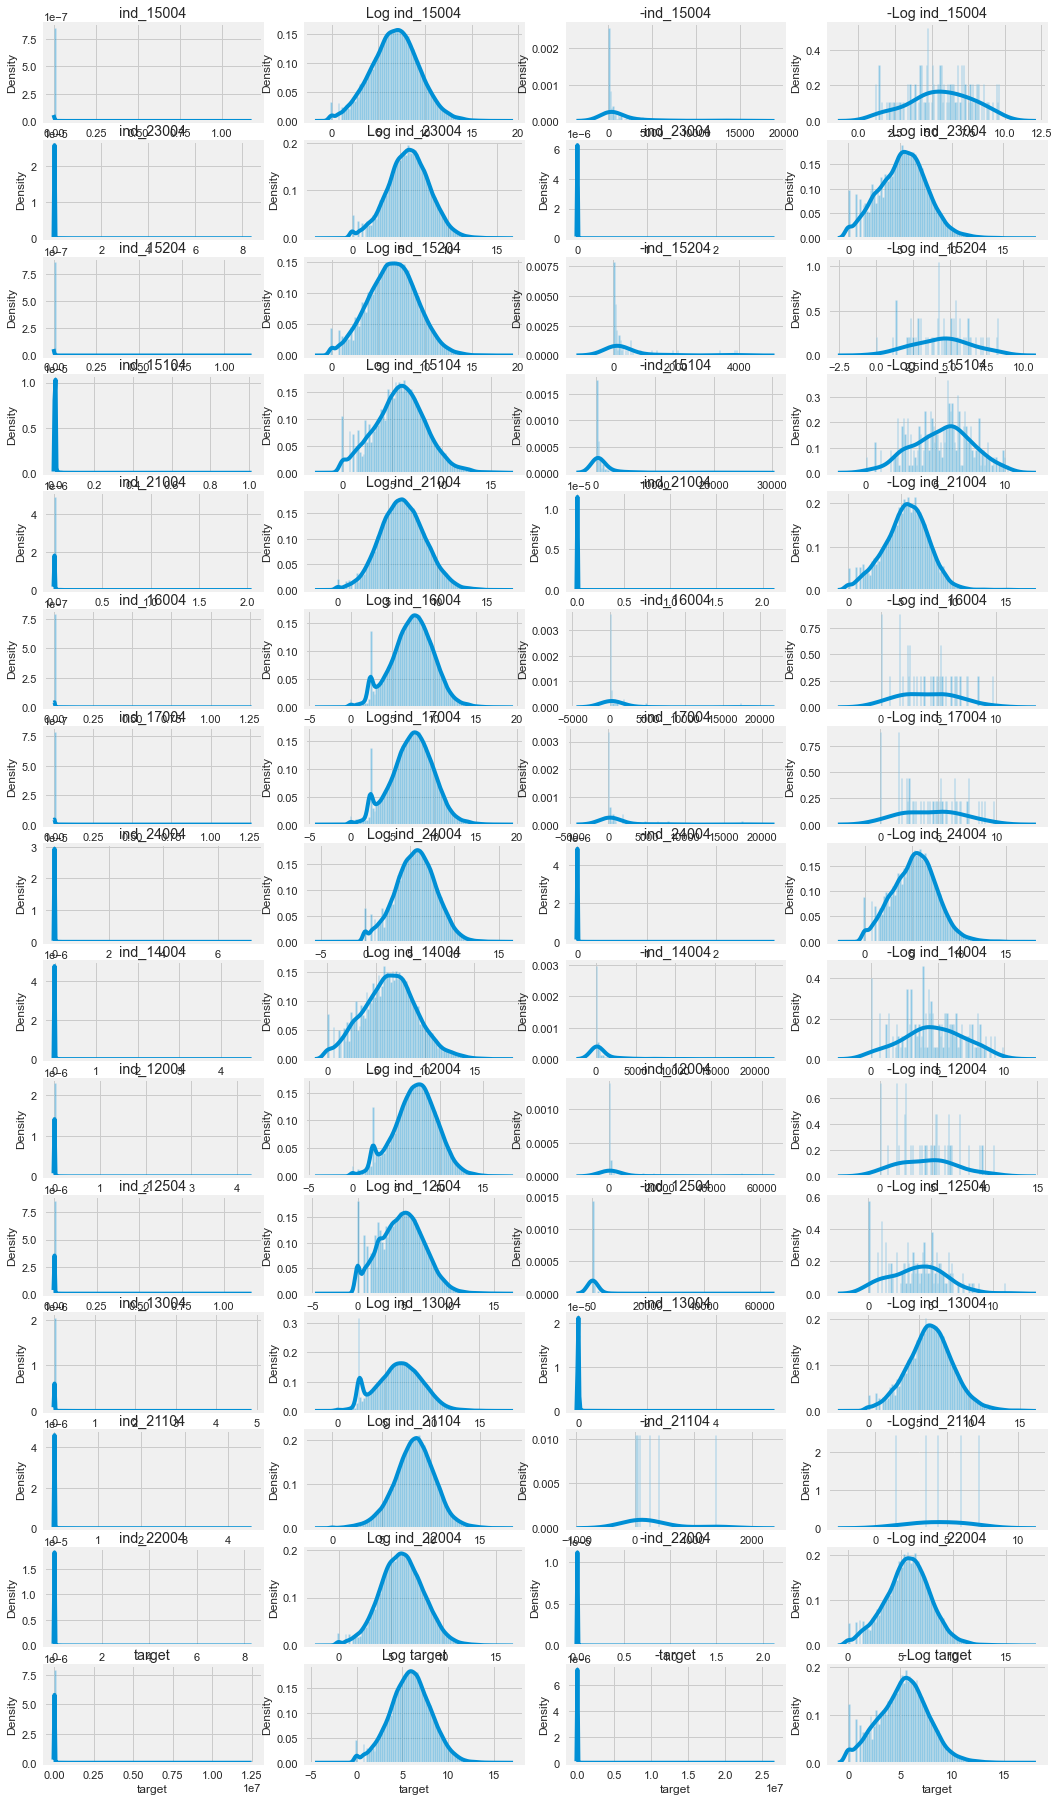

In [99]:
# Посмотрим на распеределение числовых переменных и на них после логарифмирования
num_features = [c for c in work_ds.columns if c.startswith('ind_')] + ['target']
fig, ax = plt.subplots(nrows=len(num_features), ncols=4)
fig.set_size_inches(16, 32)
for i in range(0, len(num_features)):
    pos_indices = work_ds[num_features[i]] > 0
    ax[i][0].set_title(f'{num_features[i]}')
    _ = sns.distplot(work_ds.loc[pos_indices, num_features[i]], kde=True, bins=100, ax=ax[i][0])
    ax[i][1].set_title(f'Log {num_features[i]}')
    _ = sns.distplot(np.log(work_ds.loc[pos_indices, num_features[i]]), kde=True, bins=100, ax=ax[i][1])
    neg_indices = work_ds[num_features[i]] < 0
    ax[i][2].set_title(f'-{num_features[i]}')
    _ = sns.distplot(-work_ds.loc[neg_indices, num_features[i]], kde=True, bins=100, ax=ax[i][2])
    ax[i][3].set_title(f'-Log {num_features[i]}')
    _ = sns.distplot(np.log(-work_ds.loc[neg_indices, num_features[i]]), kde=True, bins=100, ax=ax[i][3])


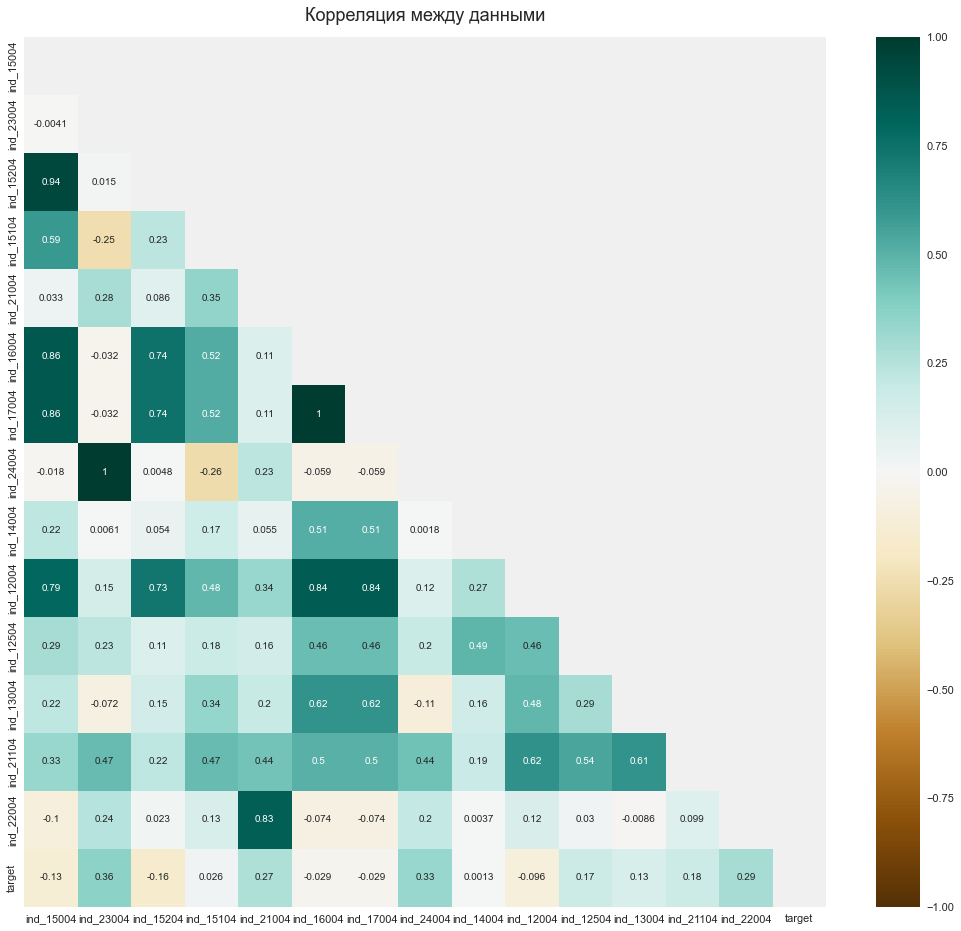

In [100]:
_ = show_num_corr(work_ds, features=[c for c in work_ds.columns if c.startswith('ind_')] + ['target'])

In [101]:
# Сильно коррелирующие индексы > 0.95
# work_ds[[c for c in work_ds.columns if c.startswith('ind_1')] + ['target']].corr().style.applymap(lambda x: "color: red" if abs(x) > 0.9 else "color: white")
high_corr_df = get_high_coreleted_features(work_ds[[c for c in work_ds.columns if c.startswith('ind_')] + ['target']], limit=0.95)
high_corr_df['feature_name_1'] = high_corr_df['feature_1'].apply(lambda x: buh_codes_dict.get(x[4:8], x))
high_corr_df['feature_name_2'] = high_corr_df['feature_2'].apply(lambda x: buh_codes_dict.get(x[4:8], x))
high_corr_df['feature_na_1'] = high_corr_df['feature_1'].apply(lambda x: work_ds[x].isna().sum())
high_corr_df['feature_na_2'] = high_corr_df['feature_2'].apply(lambda x: work_ds[x].isna().sum())
high_corr_df

,feature_1,feature_2,value,feature_name_1,feature_name_2,feature_na_1,feature_na_2
0,ind_23004,ind_24004,0.995596,Прибыль (убыток) до налогообложения,Чистая прибыль (убыток),8876,9054
1,ind_16004,ind_17004,0.999999,БАЛАНС (актив),БАЛАНС (пассив),6356,6352


In [102]:
# Сразу удалим сильно коррелирующие признаки
work_ds.drop(['ind_16004', 'ind_24004'], axis=1, inplace=True, errors='ignore')

In [103]:
# Так как дальше пойдет удаление строк - сразу отделим набор, для окончательной валидации
train_indices, test_indices = train_test_split(work_ds.index, test_size=0.2, random_state=RANDOM_SEED)

In [104]:
# Убрать все у гого индексы пропущены
# work_ds = work_ds[(work_ds[[c for c in work_ds.columns if c.startswith('ind_')]].isna().sum(axis=1) != len(num_features))]
# work_ds.info()

In [105]:
# Выбросы в таргете
out_indices = outliers(work_ds, 'target', iqrs=1.5).index
work_ds.loc[out_indices]

25-й перцентиль: -3.0, 75-й перцентиль: 753.0, IQR: 756.0, Границы выбросов: [-1137.0, 1887.0]


,okfs,ind_15004,measure,okopf,target,ind_23004,ind_15204,okpo,ind_15104,ind_21004,...,ind_14004,org_inn,subject_rf,ind_12004,ind_12504,ind_13004,okved,ind_21104,name,ind_22004
1,16,7960.0,384,12300,-2610.0,70.0,6104.0,26748262,1855.0,-219.0,...,NaN,6025050565,60,1256.0,NaN,-6669.0,60.10,2868.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ДОМ ...",-219.0
4,16,77265.0,384,12300,7659.0,3920.0,76352.0,34464024,913.0,76208.0,...,6500.0,6234143407,62,94010.0,4964.0,11372.0,47.62.2,154917.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КАНЦ...",6425.0
8,16,2959.0,384,65,3786.0,1435.0,696.0,62562033,2263.0,1899.0,...,NaN,6674334392,66,4286.0,4.0,4540.0,73.11,6490.0,"Общество с ограниченной ответственностью РПК ""...",1899.0
9,16,10518.0,384,65,-3466.0,-3642.0,10518.0,69543317,NaN,-3768.0,...,NaN,6658372792,66,13563.0,10.0,3100.0,73.11,4769.0,"Общество с ограниченной ответственностью ""Брен...",-3768.0
13,16,895.0,384,65,3380.0,6202.0,895.0,75764933,NaN,6242.0,...,NaN,6658198819,66,12526.0,2074.0,13855.0,31.09,27754.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АМИАНТ""",6242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85372,16,4865.0,384,12300,-1774.0,1225.0,4865.0,40692999,NaN,18428.0,...,113.0,4027023450,40,11060.0,4256.0,17509.0,58.13,62058.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АГЕН...",1196.0
85374,16,12269.0,384,12300,70027.0,55753.0,11829.0,49776901,NaN,75187.0,...,NaN,5262316240,99,27001.0,20185.0,16261.0,60.20,104338.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ТНТ-...",55340.0
85384,16,NaN,384,12300,3048.0,-20.0,NaN,6287735,NaN,NaN,...,NaN,7816629808,78,20.0,20.0,20.0,73.11,NaN,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОУЛ ...",NaN
85391,16,5341.0,384,12300,-15901.0,-1036.0,3675.0,16745140,1666.0,-97.0,...,NaN,4345468830,43,3389.0,423.0,-1133.0,31.01,3333.0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ФАБР...",-932.0


In [106]:
# Без их удаления точность модели значительно падает
# work_ds.drop(out_indices, axis=0, inplace=True)
# work_ds.info()

### Fill NaN

In [107]:
# Пропуски заполним средними показателями по ОКВЕД
for f in [c for c in work_ds.columns if c.startswith('ind_')]:
    ind_dict = work_ds.groupby(by=['okved', 'subject_rf'])[f].median().fillna(0).to_dict()
    nan_indices = work_ds[f].isna()
    work_ds.loc[nan_indices, f] = work_ds.apply(lambda row: ind_dict[(row['okved'], row['subject_rf'])], axis=1)
# for f in num_features:
#     X.fillna(work_ds[f].median(), inplace=True)
# X.fillna(0, inplace=True)
work_ds.isna().sum()

okfs                0
ind_15004           0
measure             0
okopf               0
target              0
ind_23004           0
ind_15204           0
okpo                0
ind_15104           0
ind_21004           0
ind_17004           0
subject_rf_isNAN    0
extra_field         0
type                0
ind_14004           0
org_inn             0
subject_rf          0
ind_12004           0
ind_12504           0
ind_13004           0
okved               0
ind_21104           0
name                0
ind_22004           0
dtype: int64

### Feature enginearing

In [108]:
work_ds.describe()

,ind_15004,target,ind_23004,ind_15204,ind_15104,ind_21004,ind_17004,extra_field,ind_14004,ind_12004,ind_12504,ind_13004,ind_21104,ind_22004
count,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04,6.895000e+04
mean,2.389678e+04,2.178713e+03,1.703350e+03,1.782472e+04,4.140499e+03,7.287591e+03,4.101693e+04,2.019047e+07,6.437585e+03,2.725870e+04,3.402443e+03,1.183440e+04,3.902377e+04,1.973347e+03
std,5.467568e+05,1.499069e+05,1.391324e+05,4.933182e+05,1.013351e+05,1.577964e+05,7.774289e+05,2.292772e+03,2.142907e+05,3.610355e+05,8.816501e+04,3.320071e+05,4.569063e+05,1.119114e+05
min,-1.533200e+04,-2.659817e+07,-2.831406e+07,-3.959000e+03,-2.704000e+04,-2.116299e+07,-1.746300e+04,2.007103e+07,-2.000000e+04,-5.204800e+04,-5.957400e+04,-5.639676e+06,-1.379000e+03,-2.116299e+07
25%,2.130000e+02,-3.000000e+00,1.000000e+00,1.580000e+02,1.460000e+02,5.100000e+01,3.670000e+02,2.019033e+07,2.450000e+02,3.190000e+02,3.100000e+01,1.200000e+01,1.439000e+03,1.400000e+01
50%,9.470000e+02,9.000000e+01,1.190000e+02,7.160000e+02,2.700000e+02,3.125000e+02,1.718000e+03,2.019043e+07,4.100000e+02,1.450000e+03,1.220000e+02,2.950000e+02,4.495000e+03,1.650000e+02
75%,3.677750e+03,7.530000e+02,6.490000e+02,2.786750e+03,5.810000e+02,1.485000e+03,7.484500e+03,2.019071e+07,8.610000e+02,6.122750e+03,4.810000e+02,1.860000e+03,1.240600e+04,7.530000e+02
max,1.174417e+08,1.246320e+07,8.367762e+06,1.158923e+08,1.003891e+07,2.037662e+07,1.259224e+08,2.020032e+07,4.715816e+07,4.305063e+07,1.158983e+07,4.862135e+07,4.521980e+07,8.274410e+06


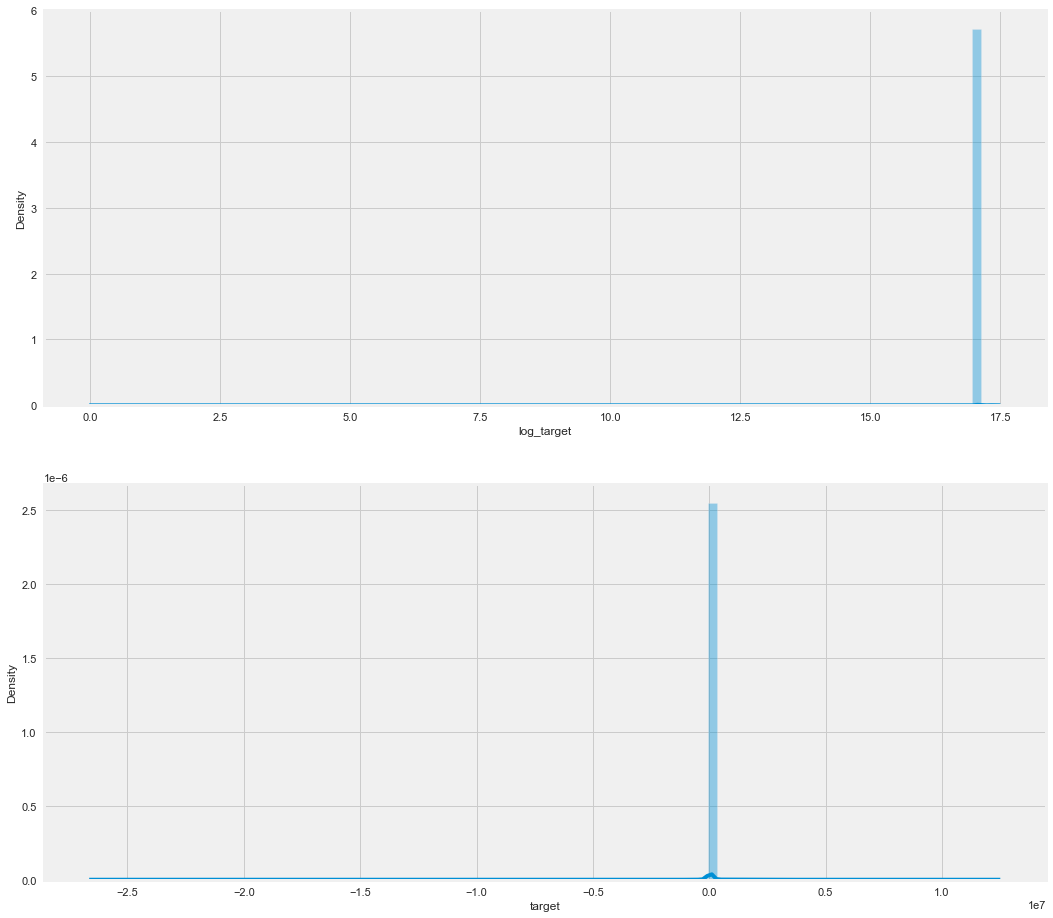

In [109]:
# Попробуем сместить в полжительную область таргет и прологарифмировать
min_target = work_ds['target'].min()
work_ds['log_target'] = np.log(work_ds['target'] + abs(min_target) + 1)
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 16)
_ = sns.distplot(work_ds['log_target'], kde=True, bins=100, ax=ax[0])
_ = sns.distplot(work_ds['target'], kde=True, bins=100, ax=ax[1])

In [110]:
dollar = pd.read_csv('data/dollar.csv', sep=';', decimal=',')
dollar['data'] = pd.to_datetime(dollar['data'])
dollar['curs'] = dollar['curs'].astype(float)
dollar['year'] = dollar['data'].dt.year
dollar.head()

,nominal,data,curs,cdx,year
0,1,2021-12-14,73.4107,Доллар США,2021
1,1,2021-11-12,73.6059,Доллар США,2021
2,1,2021-10-12,73.5998,Доллар США,2021
3,1,2021-09-12,73.8453,Доллар США,2021
4,1,2021-08-12,74.1399,Доллар США,2021


In [111]:
dollar_dict = dollar.groupby('year')['curs'].mean().to_dict()
dollar_dict

{2014: 55.77043636363636,
 2015: 61.319434817813764,
 2016: 66.83347177419355,
 2017: 58.29818461538461,
 2018: 62.92638947368421,
 2019: 64.61843211382114,
 2020: 72.32300205761317,
 2021: 73.66828978723404}

In [112]:
# Создадим признаки, логарифм индекса и знак индекса (приведет распределение индекса к более нормальному)
# Позже можно попробовать преобразование бокса-кокса или другие, работающие с неположительными признаками
for column in [c for c in work_ds.columns if c.startswith('ind_')]:
    work_ds[f'sign_{column}'] = work_ds[column].apply(lambda x: 0 if x == 0 else -1 if x < 0 else 1)
    work_ds[f'log_{column}'] = work_ds[column].apply(lambda x: 0 if x == 0 else np.log(-x) if x < 0 else np.log(x))
work_ds.head()

,okfs,ind_15004,measure,okopf,target,ind_23004,ind_15204,okpo,ind_15104,ind_21004,...,sign_ind_12004,log_ind_12004,sign_ind_12504,log_ind_12504,sign_ind_13004,log_ind_13004,sign_ind_21104,log_ind_21104,sign_ind_22004,log_ind_22004
0,16,95.0,384,12300,81.0,131.0,95.0,25053919,140.0,245.0,...,1,5.209486,1,4.394449,1,4.477337,1,5.843544,1,5.402677
1,16,7960.0,384,12300,-2610.0,70.0,6104.0,26748262,1855.0,-219.0,...,1,7.135687,1,4.927254,-1,8.805225,1,7.961370,-1,5.389072
2,16,1.0,384,12300,0.0,-7.0,360.0,27234766,1.0,326.0,...,1,6.919684,1,4.394449,-1,0.000000,1,8.313485,1,5.129899
4,16,77265.0,384,12300,7659.0,3920.0,76352.0,34464024,913.0,76208.0,...,1,11.451156,1,8.509967,1,9.338909,1,11.950645,1,8.767952
5,16,9.0,384,12300,282.0,48.0,8.0,37407601,1.0,55.0,...,1,4.077537,1,4.077537,1,3.912023,1,4.276666,1,4.007333


### Prepare data for model

In [113]:
# Определимся с признаками
num_features = [c for c in work_ds.columns if c.startswith('log_ind_')]
cat_features = ['type', 'subject_rf', 'okved'] + [c for c in work_ds.columns if c.startswith('sign_ind_')]
bin_features = ['subject_rf_isNAN']
target = 'target'
y = work_ds[target]
# [(n, buh_codes_dict[n[4:8]]) for n in num_features]

In [114]:
# Привести к доллару (ничего не дает)
# for f in num_features:
#     work_ds[f] = work_ds.apply(lambda row: row[f] / dollar_dict[row['year']], axis=1)

In [115]:
#ohe = preprocessing.OneHotEncoder()
#ohe.fit_transform()
X = pd.get_dummies(work_ds[num_features + cat_features + bin_features], columns=cat_features)
X.head()

,log_ind_15004,log_ind_23004,log_ind_15204,log_ind_15104,log_ind_21004,log_ind_17004,log_ind_14004,log_ind_12004,log_ind_12504,log_ind_13004,...,sign_ind_12504_1,sign_ind_13004_-1,sign_ind_13004_0,sign_ind_13004_1,sign_ind_21104_-1,sign_ind_21104_0,sign_ind_21104_1,sign_ind_22004_-1,sign_ind_22004_0,sign_ind_22004_1
0,4.553877,4.875197,4.553877,4.941642,5.501258,5.209486,7.792762,5.209486,4.394449,4.477337,...,1,0,0,1,0,0,1,0,0,1
1,8.982184,4.248495,8.716700,7.525640,5.389072,7.163172,6.928538,7.135687,4.927254,8.805225,...,1,1,0,0,0,0,1,1,0,0
2,0.000000,1.945910,5.886104,0.000000,5.786897,7.134094,6.285067,6.919684,4.394449,0.000000,...,1,1,0,0,0,0,1,0,0,1
4,11.254996,8.273847,11.243110,6.816736,11.241222,11.463073,8.779557,11.451156,8.509967,9.338909,...,1,0,0,1,0,0,1,0,0,1
5,2.197225,3.871201,2.079442,0.000000,4.007333,4.077537,0.000000,4.077537,4.077537,3.912023,...,1,0,0,1,0,0,1,0,0,1


In [116]:
scaler = preprocessing.MinMaxScaler()
X[num_features] = scaler.fit_transform(X[num_features])
X.head()

,log_ind_15004,log_ind_23004,log_ind_15204,log_ind_15104,log_ind_21004,log_ind_17004,log_ind_14004,log_ind_12004,log_ind_12504,log_ind_13004,...,sign_ind_12504_1,sign_ind_13004_-1,sign_ind_13004_0,sign_ind_13004_1,sign_ind_21104_-1,sign_ind_21104_0,sign_ind_21104_1,sign_ind_22004_-1,sign_ind_22004_0,sign_ind_22004_1
0,0.280554,0.393039,0.280745,0.374577,0.381647,0.392464,0.441041,0.412474,0.410241,0.327164,...,1,0,0,1,0,0,1,0,0,1
1,0.507673,0.362072,0.494393,0.519125,0.375543,0.480767,0.392129,0.503972,0.436710,0.547396,...,1,1,0,0,0,0,1,1,0,0
2,0.046995,0.248297,0.349119,0.098144,0.397186,0.479453,0.355711,0.493712,0.410241,0.099327,...,1,1,0,0,0,0,1,0,0,1
4,0.624241,0.560973,0.624056,0.479469,0.693908,0.675113,0.496890,0.708967,0.614699,0.574553,...,1,0,0,1,0,0,1,0,0,1
5,0.159686,0.343429,0.153750,0.098144,0.300375,0.341303,0.000000,0.358704,0.394497,0.298397,...,1,0,0,1,0,0,1,0,0,1


In [117]:
X_train, X_test, y_train, y_test, _, y_true = train_test_split(X, y, work_ds['target'], test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_true.shape

((55160, 217), (13790, 217), (55160,), (13790,), (13790,))

### Naive model

In [118]:
# Простая линейная модель
model = RidgeCV().fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.mean_absolute_percentage_error(y_test, y_pred), metrics.mean_absolute_error(y_test, y_pred)

(2.2091095895369687e+18, 14041.079798361256)

In [119]:
list(zip(y_pred, y_test))[:10]

[(-12932.93247835205, 397.0),
 (8730.218747860781, 0.0),
 (-5353.85765712447, 4.0),
 (7194.578009849109, 2381.0),
 (2917.125484664466, 1216.0),
 (2854.3243716022116, 5.0),
 (5789.048704235771, 1878.0),
 (4765.111636711619, -14387.0),
 (6612.9103723863955, 77.0),
 (9973.47144685303, 759.0)]

In [120]:
# model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED).fit(X_train, y_train)
# y_pred = model.predict(X_test)
# metrics.mean_absolute_percentage_error(y_test, y_pred), metrics.mean_absolute_error(y_test, y_pred)

In [121]:
# plot_feature_imortances(model.feature_importances_, X.columns)

Model best C [0.04641589]
ROC AUC = 0.7294846431118654


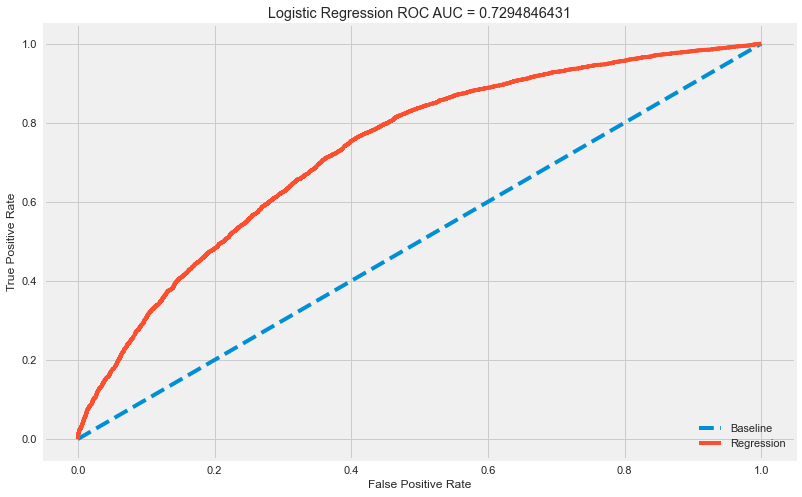

cross_auc = [0.72468817 0.72822633 0.72619829 0.72479304 0.72527368]


0.7258359026096118

In [122]:
# Предсказание номинального значения дает очень плохие результаты
# Попробуем упростить задачу - предсказать прибыльностью/убыточность предеприятия в следующем году
lr = LogisticRegressionCV(Cs=10, cv=5, verbose=0, max_iter=2000, random_state=RANDOM_SEED, n_jobs=-1, scoring='roc_auc')
lr.fit(X_train, y_train > 0)
print('Model best C', lr.C_)
y_prob = lr.predict_proba(X_test)[:, 1]
best_roc_auc = roc_auc_score(y_test > 0, y_prob)
print(f'ROC AUC = {best_roc_auc}')
show_roc_auc(y_test > 0, y_prob)
cross_auc = cross_val_score(lr, X, y > 0, cv=5, scoring='roc_auc')
print('cross_auc =', cross_auc)
np.mean(cross_auc)

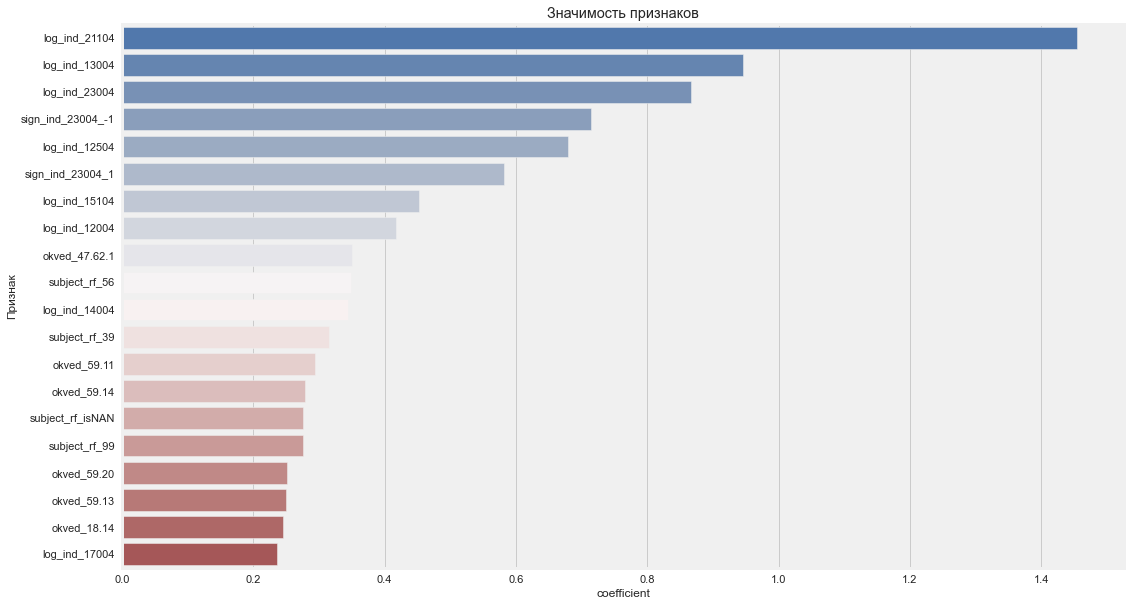

In [123]:
show_lr_Importance(lr, X.columns)

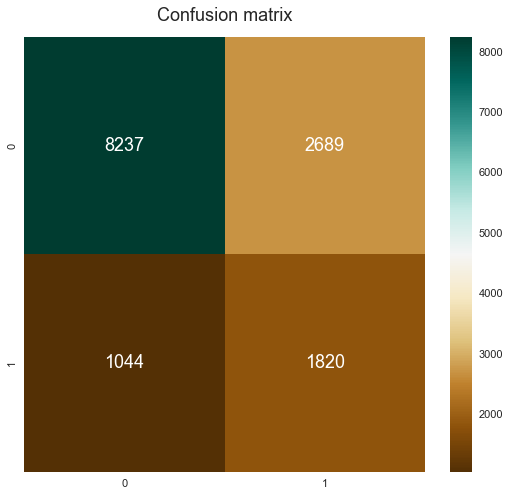

In [124]:
# Посмотрим какие ошибки чаще
lr = LogisticRegressionCV(Cs=10, cv=5, verbose=0, max_iter=2000, random_state=RANDOM_SEED, n_jobs=-1, scoring='roc_auc')
lr.fit(X_train, y_train > 0)
y_pred = lr.predict(X_test)
show_confusion_matrix(y_test > 0, y_pred)

In [125]:
print_clssification_metrix(y_test > 0, y_pred)

Precision: 0.7538898041369211
Recall: 0.8875121215386274
F1-score: 0.815262037907656


In [126]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [127]:
# Гораздо лучше, дает надежду, что решение задачи возможно